# Introduction 

Dans ce fichier nous allons mettre en place une implémentation basique de l'algorithme proposé dans l'article à étudier.

Nous allons pour l'instant étudier le dataset Extended Yale B.

Les données sont présentes dans le dossier suivant : data/CroppedYale/

Ne pas faire "Run all", il y a des étapes de recherche de paramètre optimal type gridsearch qu'il ne faut pas relancer car elles sont trop longues.

# Utilisation du notebook 

Ce notebook reprend notre implémentation de l'article. Afin de pouvoir générer les résultats (et de changer la fenêtre d'étude) il est possible de change certaines variables. Nous les indiquerons auparavant.

### TODO

* Pouvoir charger des images automatiquement à partir de l'id
* Reconstruction d'une image à partir des coefficients et comparaison à l'image originale.

# Imports 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from PIL import Image
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import time
import random

In [3]:
random.seed(2017) # For reproductibility

# Définition de fonctions utiles

Définition de la fonction delta_i, indicatrice de la classe i.

In [4]:
def delta(x,i,classs):
    '''
    fonction indicatrice de la classe i
    '''
    n,m = len(x),len(classs)
    
    if (n != m):
        print 'vectors of differents sizes, cannot operate delta'
        
    tmp = i*np.ones(n)-classs

    for k in range(n):
        if tmp[k]==0:
            tmp[k]=1
        else:
            tmp[k]=0 
            
    return tmp*x

Définition de la fonction de résidu qui renvoie la classe minimisant l'erreur de reconstruction suivant la norme L2.

In [5]:
def residu(y,A,x,class_x):
    '''
    renvoie les residus pour chaque classe.
    '''
    k = np.max(class_x)+1
    r = np.zeros(k)
    
    for i in range(0,k):
        r[i] = np.linalg.norm(y - np.dot(A,delta(x,i,class_x)))
        
    return r

Définition de la fonction retournant l'indice de concentration (_Sparsity Concentration Index_)

In [6]:
def SCI(x,classs):
    '''
    @input
      - classs: classe de chaque training element.
      - x     : sparse coefficients
    '''
    
    k = len(set(classs)) # Nombre de classes différentes
    
    # Puis on retourne la valeur du SCI
    return (k*(1/np.linalg.norm(x,ord=1))*np.max([np.linalg.norm(delta(x,i,classs),ord=1) for i in range(k)]) - 1)/(k-1)
    

**Utilitaire** : trouver la classe d'un élément du test set pour le Yale Database

In [7]:
def find_class(i):
    return int(i)/12

**Utilitaire** : fonction pour charger les fichiers

In [8]:
def read_images(path, sz=None): 
    '''
    Chargement des données
    Si spécifiée, réduction de dimensions incluse
    '''
    c=0
    X,y = [], []
    for dirname , dirnames , filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path , filename)) 
                    im = im.convert("L")
                    # resize to given size (if given)
                    if (sz is not None):
                        im = im.resize(sz, Image.NEAREST)     
                    X.append(np.asarray(im, dtype=np.uint8)) 
                    y.append(c)
                except IOError:
                    pass
                except:
                    print "Unexpected error:", sys.exc_info()[0] 
                    raise
            c = c+1
            print c
    return [X,y]

# Chargement des images 

** Choix du mode de réduction de features **

Modes de réduction de dimension :

* reduced_fs_dimension : réduction de dimension classique
* fisherfaces
* eigenfaces
* randomfaces

In [9]:
mode_reduc_features = 'eigenfaces'
size_features = (12,10) # Egalement utilisé plus bas !

n_components = size_features[0]*size_features[1]

print("Réduction de features choisie : ", mode_reduc_features)

('R\xc3\xa9duction de features choisie : ', 'eigenfaces')


** Chargement des images **

In [10]:
if ((mode_reduc_features == 'randomfaces') & (size_features != None)):
    X, y = read_images('data/CroppedYale', sz=size_features)
elif ((mode_reduc_features != 'reduced_fs_dimension') & (mode_reduc_features != None)):
    X, y = read_images('data/CroppedYale', sz=None)
else :
    X, y = read_images('data/CroppedYale', sz=(12,10))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


Vérification qu'on a bien chargé les données des individus

In [11]:
print "Nombre d'éléments chargés ",len(X)

Nombre d'éléments chargés  2470


Alright : on a bien chargé 64 images qui ont été fournies, par individu (plusieurs illuminations)

## Retraitement du dataset 

Nous allons dans un premier temps supprimer toutes les images "toutes noires" (premières images pour chaque individu, indiquées par le libellé "ambient".

In [12]:
X_new = []
y_new = []

for i in range(len(X)):
    if i%65!=0:
        X_new.append(X[i])
        y_new.append(y[i])

## Séparation du dataset en train et test 

A chaque personne sont associées 64 images stockées dans _X_new_ :

* 29 images "négatives" (ex : yaleB01_P00A**-**005E-10)
* 35 images "positives" (ex : yaleB01_P00A**+**050E-40)

_Note :_ Une bonne partie des images est quasiment illisible (très mauvaise luminosité)

Afin d'avoir un test set et un train set à peu près homogènes, on va prendre 12 images de test pour 52 images de train (~19% dans le test), soit :

* 5 images "négatives"
* 7 images "positives"

In [13]:
X_train, X_test = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X_new)):
    if i%64==0:
        # On compute les indices des éléments à placer dans le test, ils sont différents pour chaque image.
        test1 = np.random.choice(28,5,replace=False)
        test2 = 29 + np.random.choice(35,7,replace=False)
    
    # On crée X_test et X_train
    if ((i%64 in test1) or (i%64 in test2)):
        X_test.append(X_new[i])
        ytest.append(y_new[i])
        indices_test.append(i)
    else:
        X_train.append(X_new[i])
        ytrain.append(y_new[i])
        indices_train.append(i)

## Manipulation des matrices

On déroule chaque image en un vecteur puis on les concatène.

In [14]:
X_toconcat_train = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_train]
X_toconcat_test = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_test]

# Puis concaténation pour avoir une matrice unique
Xtrain = np.concatenate(X_toconcat_train,axis=1) # Liste des samples du train, concaténés en colonne.
Xtest = np.concatenate(X_toconcat_test,axis=1) # Liste des samples du test, concaténés en colonne.

## Réduction de dimension

La réduction de dimensions peut déjà être inclue dans le chargement des images si l'on fait juste de la réduction de dimension basique. Mais on peut également choisir une méthode plus évoluée !

_ Ne pas oublier de renseigner la variable **size_features** plus haut _

Pour observer le détail des fonctions, voir le fichier **features_reduction.py**

In [15]:
from features_reduction import *

Normalisation

In [16]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.fit_transform(Xtest)

/Users/maxwab/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [17]:
if (mode_reduc_features == 'eigenfaces'):
    Xtrain, Xtest = eigenfaces(Xtrain.T,Xtest.T,n_components=n_components)
    Xtrain, Xtest = Xtrain.T, Xtest.T
elif (mode_reduc_features == 'fisherfaces'):
    Xtrain, Xtest = fisherfaces(Xtrain.T,ytrain,Xtest.T,n_components=n_components)
    Xtrain, Xtest = Xtrain.T, Xtest.T
elif (mode_reduc_features == 'randomfaces'):
    Xtrain, Xtest = randomfaces(Xtrain.T, Xtest.T, n_components=n_components)
    Xtrain, Xtest = Xtrain.T, Xtest.T
    
# Note : on n'oublie pas de transposer pour pouvoir utiliser les fonctions de features_reduction

Extracting the top 120 eigenfaces from 1976 faces
done in 9.850s
Projecting the input data on the eigenfaces orthonormal basis
EigenFaces done in 0.964s


In [18]:
print('Taille du nouveau dataset',Xtest.shape)

('Taille du nouveau dataset', (120, 456))


On a bien la bonne taille !

# Implémentation de l'algorithme 1 

In [19]:
from sklearn.linear_model import Lasso

On voit dans la littérature que cela revient à traiter le problème Lasso.

D'abord on crée un vecteur d'$\alpha_i$ à tester avec Lasso.

Puisqu'on utilise la fonction Lasso il est nécessaire d'adapter nos $\alpha_i$ à la dimension de $y$.

In [20]:
alpha_vec = np.logspace(2,4,20)
alpha_vec = alpha_vec/(Xtest.shape[0])

Puis on utilise Lasso pour trouver la solution à notre problème.

In [21]:
#for i, alpha in enumerate(alpha_vec):

testval = 318 # Id : élément du test set à évaluer grâce à notre algorithme.

clf = Lasso(alpha=0.02) #on prend l'alpha courant
clf.fit(Xtrain,Xtest[:,testval])
x = clf.coef_

** Affichage des résultats **

In [22]:
print "Classe réelle: ", ytest[testval]
print "Classe prédite: ",np.argmin(residu(Xtest[:,testval],Xtrain,x,ytrain))
print "Rejection: ", SCI(x,ytrain)

Classe réelle:  26
Classe prédite:  26
Rejection:  0.6163241502


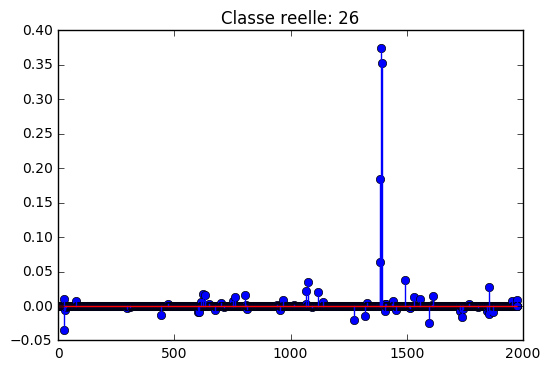

In [23]:
plt.figure()
plt.stem(x)
plt.title('Classe reelle: ' + str(ytest[testval]))

Avantage : meilleure interprétabilité des résultats : on sait où il y a des erreurs et pourquoi il y a des erreurs.

On s'intéresse également aux résidus

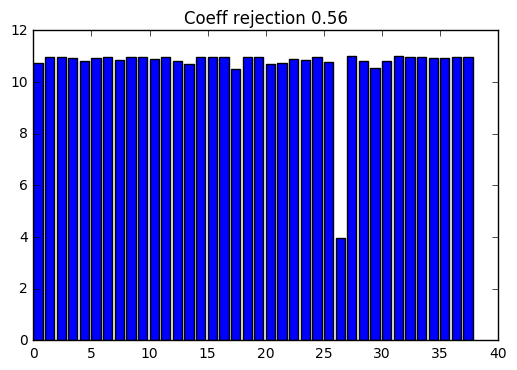

In [75]:
plt.figure()
plt.clf()
plt.bar(range(38),residu(Xtest[:,testval],Xtrain,x,ytrain))
plt.title('Coeff rejection ' + str(np.round(SCI(x,ytrain),2)))

### Reconstruction de l'image

### Identification du meilleur lambda pour la régularisation, performance sans rejection

On va regarder la précision de notre algorithme pour différents lambda.

La métrique sera le _pourcentage de bonne classification_.

In [ ]:
# Rappel : 
# * y : Elément à tester (est une colonne de Xtest)
# * Xtrain : Matrice A des exemples d'entrainement
# * x : coefficients issus de la minimisation LASSO
# * ytrain : classe des exemples d'entrainement

preds = np.zeros((len(alpha_vec),Xtest.shape[1]))
rejections = np.zeros((len(alpha_vec),Xtest.shape[1]))

for i, alpha in enumerate(alpha_vec):
    t = time.time()
    print "Coefficient de régularisation: ", alpha
    print "Boucle #",i+1,"/",len(alpha_vec)
    clf = Lasso(alpha=alpha) # on crée un modèle avec l'alpha courant
    for j in range(Xtest.shape[1]):
        # Pour chaque exemple à tester on génère les coefficients et on prend la meilleure prédiction
        y = Xtest[:,j]
        clf.fit(Xtrain,y)
        x = clf.coef_
        
        # On fait la prédiction
        preds[i,j] = np.argmin(residu(y,Xtrain,x,ytrain)) 
        rejections[i,j] = SCI(x,ytrain)
        
        # Affichage d'un message pour suivre l'avancement de l'algorithme
        
        if (j%50 == 0):
            print j, "exemples traités en",time.time() - t ,"s"
        
    print "Temps écoulé pour la boucle : ", time.time() - t

On remarque que l'entrainement est spécialement long puisqu'on doit réentrainer un classifieur pour chaque exemple !

Mais c'est parallélisable

On calcule maintenant la précision pour chaque lambda

In [ ]:
# Définition des classes réelles
real_classes = np.reshape(ytest*len(alpha_vec),(len(alpha_vec),len(ytest)))

# Evaluation de la précision

precision = 100.0*np.sum(preds == real_classes,axis=1)/len(ytest)

**Affichage des résultats**

In [ ]:
plt.figure()
plt.clf()
plt.plot(alpha_vec,precision)
plt.title('Evolution de la precision en fonction de $\lambda$')
plt.axis([0, 20, 85,95])

Détermination du coefficient optimal de régularisation

In [ ]:
i_opt = np.argmax(precision)
alpha_opt = alpha_vec[i_opt]

In [ ]:
# Coefficient optimal :  3.56777699893
print "Coefficient optimal : ", alpha_opt

#### Etude des coefficients de rejection

In [ ]:
wrong_preds = (rejections*(preds != real_classes))[i_opt,:]

Affichage des mauvaises prédictions

In [ ]:
plt.figure()
plt.clf()
plt.stem(wrong_preds)
plt.title('SCI for wrong predictions using best $\lambda$')

On peut voir que la majorité des erreurs se trouve sur les derniers exemples, avec très peu d'erreur sur les premiers.

On a notamment constamment tort pour les 12 derniers exemples, appartenant tous à la même (la dernière) classe.
On se rend également compte qu'il ne s'agit pas d'une confusion avec une seule personne : les prédictions pour la dernière personne sont les suivantes : 
    [ 12.,  14.,  36.,  14.,  27.,   9., 27.,  17.,  22.,  17.,   8.,  19.].

In [ ]:
wrong_preds[-50:]
preds[i_opt,-50:]

** Reclassement des coefficients de rejection par classe**

Rappel : 12 exemples par classes dans le test, 38 classes.

In [ ]:
# Changer les coefficients dans zeros si changement de base.

rejec_by_class = np.zeros((12,38))

j = 0
for i in range(Xtest.shape[1]):
    if ((i%12 == 0) & (i != 0)):
        j = j+1
    rejec_by_class[i%12,j] = rejections[i_opt,i]

In [ ]:
pd.DataFrame(rejec_by_class).describe()

### Visualisation des résidus pour les exemples où l'algorithme se trompe

Choix de l'élément mal classifié #j à étudier

In [ ]:
j = 2

Obtention des résidus

In [ ]:
id_wrong_preds = np.where(preds[i_opt,:] != real_classes[i_opt,:])[0]
#for i in id_wrong_preds:
#    print find_class(i)

y = Xtest[:,id_wrong_preds[j]]
clf.fit(Xtrain,y)
x = clf.coef_

# On fait la prédiction
residus_cur = residu(y,Xtrain,x,ytrain)
rejections_cur = SCI(x,ytrain)

Affichage des résidus

In [ ]:
plt.figure()
plt.clf()
plt.bar(range(38),residus_cur)
plt.title('Real class : ' + str(find_class(id_wrong_preds[j])) + ', coeff rejection ' + str(np.round(rejections_cur,2)))

On peut observer les différents résidus pour les mauvais éléments en changeant la valeur de j. On voit que souvent (cas j = 2 par exemple), la vraie classe n'était pas très loin !

** Visualisation des images mal classifiées **

##### Partie utilisée pour sauvegarder les résultats des simulations

import pandas as pd

df_preds = pd.DataFrame(data=np.asarray(preds))
df_rejec = pd.DataFrame(data=np.asarray(rejections))

df_preds.to_csv('csv_saved/preds0.csv')
df_rejec.to_csv('csv_saved/rejec0.csv')